# Example 3 : Basic Analysis and Identifying Potential Events

In this notebook we will go through a basic perscription for analyzing MUSIC data. This typically involves a series of steps to search for the events of interest within the larger dataset. Finding the proverbial needle in the haystack (typically, by trying to reduce the size of the "haystack" first). For example, one set of steps could look something like

- Cut Pile-up Events
- Normalization
- Remove Bulk of Unreacted Beam Events
- Apply Cuts in Different Strips
- Plot Traces

Let's work through these steps using test MUSIC data and see what the effect of each step is on the dataset. First our usual notebook setup.

<div class="alert alert-block alert-info">
Is this the "best" order for these operations? It depends on what kind of experiment you performed. For example, in the test data we are looking for fusion events from $^{20}$Ne beam on CH$_{4}$ gas. One potential problem being, some elastic scatter reactions will look very much like fusions. So, an extra step might involve using the left and right anode strips (not summing them) to get the multiplicty in the strips for certain events. So, take the above perscription as an idea but not something set in stone to follow exactly.
</div>

In [5]:
import pandas as pd
import numpy as np
import matplotlib as mpl

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 200 # bigger figures

# Use more REVTEX-esque fonts
mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "STIXGeneral"
mpl.rcParams["mathtext.fontset"] = "stix"

# Use UPROOT and Pull the Data Into a Pandas Dataframe

Following directly from our work in example 2, we will use uproot to read the test_music_data.ROOT file and build a pandas dataframe.

In [1]:
import uproot

In [2]:
file = uproot.open("test_music_data.root")
tree = file['tree']
branches = tree.arrays()

One slight change we will make here is in addition to pulling the individual strip information into the dataframe, we will also bring the grid information too. The Frisch grid signal is similar to a total energy of the given event (so, we can use it as an additional source of information to help identify the reactions we are looking for).

In [7]:
dict_branches = {}

# strip0 first
dict_branches.update({'s0':branches['strip0'][branches['seg'] == 1]})
# segmented anode, left first then right
for i in range(1,17):
    dict_branches.update({'s%iL' % i : branches['edepl'][branches['seg'] == i]})
    dict_branches.update({'s%iR' % i  : branches['edepr'][branches['seg'] == i]})
# strip17
dict_branches.update({'s17':branches['strip17'][branches['seg'] == 1]})
# grid last
dict_branches.update({'grid':branches['grid'][branches['seg'] == 1]})

In [6]:
df = pd.DataFrame(dict_branches)

df

,s0,s1L,s1R,s2L,s2R,s3L,s3R,s4L,s4R,s5L,...,s13L,s13R,s14L,s14R,s15L,s15R,s16L,s16R,s17,grid
0,1003.0,366.0,50.0,35.0,366.0,387.0,33.0,42.0,335.0,377.0,...,463.0,34.0,35.0,457.0,462.0,33.0,49.0,445.0,402.0,1522.0
1,1091.0,356.0,41.0,37.0,366.0,376.0,32.0,36.0,361.0,368.0,...,429.0,37.0,41.0,522.0,470.0,32.0,40.0,482.0,380.0,1468.0
2,1083.0,364.0,62.0,36.0,359.0,371.0,35.0,38.0,372.0,365.0,...,447.0,37.0,38.0,501.0,471.0,32.0,39.0,483.0,402.0,1421.0
3,1002.0,362.0,43.0,37.0,341.0,359.0,35.0,37.0,380.0,411.0,...,436.0,36.0,37.0,442.0,470.0,33.0,37.0,467.0,400.0,1450.0
4,1015.0,352.0,41.0,37.0,361.0,377.0,33.0,39.0,382.0,409.0,...,444.0,33.0,37.0,441.0,442.0,34.0,43.0,463.0,366.0,1487.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267824,1040.0,338.0,63.0,36.0,360.0,381.0,37.0,36.0,377.0,419.0,...,425.0,39.0,33.0,434.0,419.0,35.0,39.0,459.0,403.0,1592.0
267825,969.0,325.0,41.0,36.0,360.0,387.0,35.0,36.0,363.0,406.0,...,437.0,38.0,36.0,460.0,448.0,34.0,38.0,479.0,384.0,1559.0
267826,958.0,327.0,49.0,40.0,355.0,362.0,32.0,37.0,361.0,401.0,...,423.0,36.0,34.0,447.0,420.0,36.0,46.0,451.0,398.0,1439.0
267827,1006.0,344.0,39.0,41.0,330.0,395.0,35.0,36.0,364.0,419.0,...,436.0,35.0,39.0,459.0,456.0,33.0,53.0,389.0,393.0,1524.0


Now that we have our data in a dataframe, we will first remove the pile-up events.

# Cut Pile-Up Events Using Strip 0

Pile-up events occur from two or more beam particles entering the detector at the same (or nearly the same) time. To remove these events we typically use Strip 0 of the anode (being the first strip beam passes through, it will "see" the most beam like events). First, let's take a look at Strip 0.

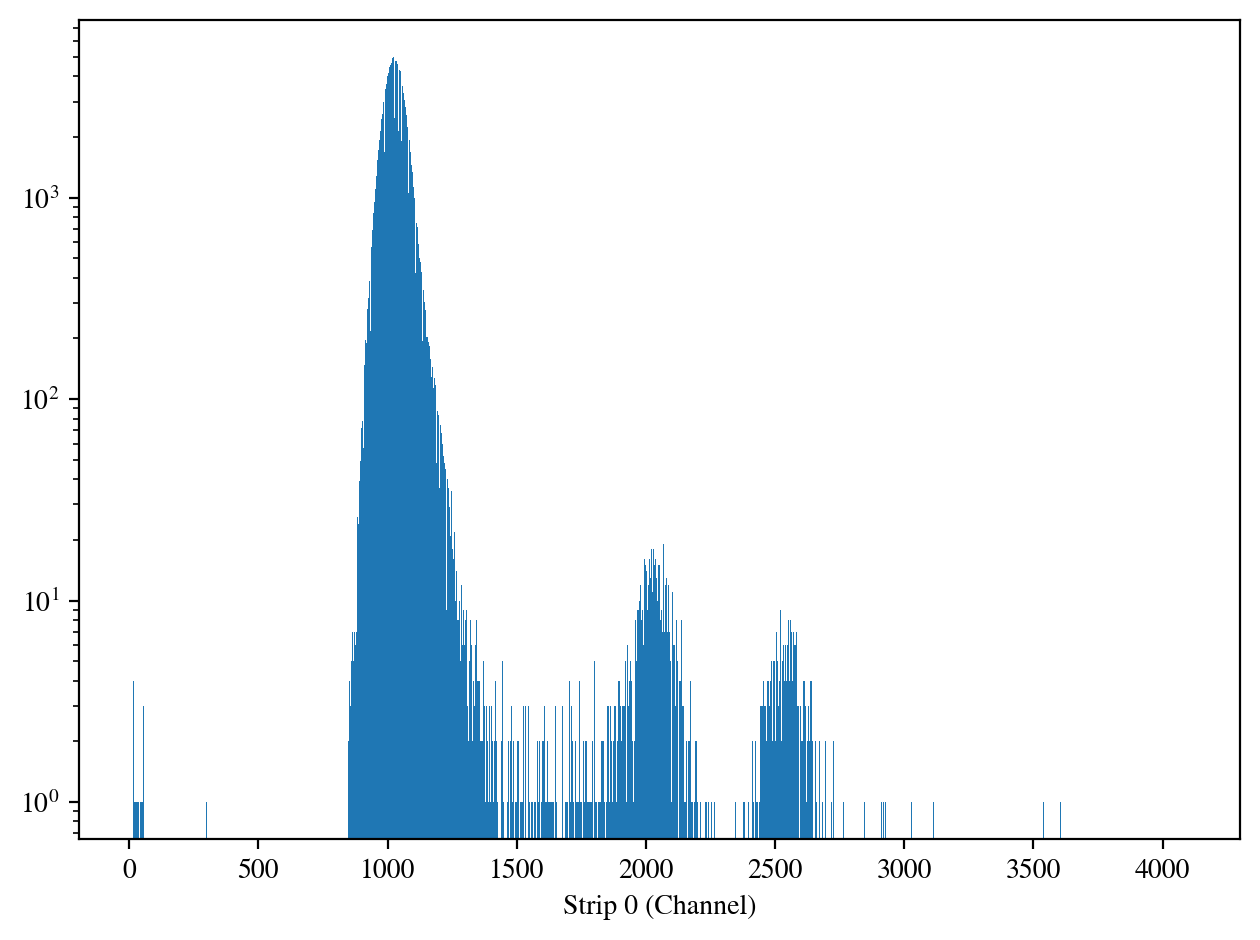

In [9]:
plt.hist(df['s0'], bins='auto')
plt.xlabel('Strip 0 (Channel)')

plt.yscale('log')

plt.tight_layout()
plt.show()